In [1]:
import tensorflow as tf
import shutil
import numpy as np
import tqdm
import pandas as pd
import os
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import random
from collections import deque
import cv2

GAMMA = 0.99
TAU = 0.01
BATCHSIZE = 128
N_BATCHES = 64
N_MULTI_ENVS = 62
EXPLORATION_RATE = 0.22
EPSILON_DECAY = 0.9999

N_NEW_SAMPLES = 500
N_SAMPLE_SETS = 100

CHECKPOINT_FREQ = 100
LOG_FREQ = 100
N_TEST_ENVS = 8
ENV_NAME = 'ALE/Breakout-v5'

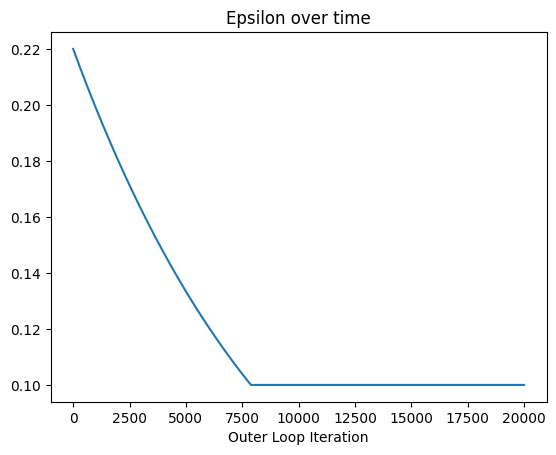

In [2]:
%matplotlib inline
x = np.arange(20000)
y = EXPLORATION_RATE * (EPSILON_DECAY ** x)
y = np.maximum(y, 0.1)

plt.plot(x,y)
plt.title("Epsilon over time")
plt.xlabel("Outer Loop Iteration")
plt.show()

In [3]:
TMP_SAVE_TO_PATH = "breakout/ckps/ckpt"
TMP_LOG_PATH = "breakout/logs/{}.json"
TB_LOGS = "breakout/tb_lobs/run"


os.makedirs(TMP_SAVE_TO_PATH.replace("/ckpt",""), exist_ok= True)
os.makedirs(TMP_LOG_PATH.replace("/{}.json",""), exist_ok= True)
os.makedirs(TB_LOGS, exist_ok= True)

# # get old checkpoint
# !cp /content/gdrive/MyDrive/DeepRL/HW4/checkpoint.zip checkpoint.zip
# !unzip -d {TMP_SAVE_TO_PATH} checkpoint.zip

LOSS = tf.keras.losses.Huber()
CNN_SHAPE = (84, 84)

In [4]:
def triple_conv_block_no_batchnorm(x, filters):

    x = tf.keras.layers.Conv2D(
        filters, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(
        filters, 3, padding='same', activation='relu')(x) + x
    x = tf.keras.layers.Conv2D(
        filters, 3, padding='same', activation='relu')(x) + x

    return x

def get_small_dqn():
    tf.keras.backend.clear_session()

    inputs = tf.keras.layers.Input((84, 84, 4,))
    x = triple_conv_block_no_batchnorm(inputs, 10)
    x = tf.keras.layers.MaxPool2D(2)(x)
    x = triple_conv_block_no_batchnorm(x, 20)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(512, "relu")(x)
    outputs = tf.keras.layers.Dense(4, "linear")(x)

    model = tf.keras.Model(inputs, outputs, name="standard_dqn")

    return model


@tf.function
def sample_trajectory(dqn, state, epsilon=0.2):

    n_par = tf.shape(state)[0]

    mask = tf.random.uniform((n_par,), 0, 1, tf.float32) > epsilon

    predictions = dqn(state, training=False)
    max_actions = tf.math.argmax(predictions, axis=-1)

    random_choices = tf.random.uniform(
        shape=[n_par], minval=0, maxval=4, dtype=tf.int64)

    return tf.where(mask, max_actions, random_choices), tf.reduce_max(predictions, -1)


class ENV_SAMPLER:
    """
    Class for sampling environment data using a DQN model.
    """

    def __init__(self, dqn, n_multi_envs, stack_frames = 4) -> None:
        """
        Initialize the ENV_SAMPLER instance.

        Args:
            env: The environment to sample from.
            dqn: The DQN model for action selection.
            n_multi_envs: The number of parallel environments.
            preprocess_observation: Function to preprocess observations.
        """
        
        self.env = gym.vector.make(ENV_NAME, num_envs=n_multi_envs)
        self.dqn = dqn
        self.n_multi_envs = n_multi_envs
        self.stack_frames = stack_frames
        self.current_state = self.env.reset()[0]
        
        self.frames = [deque([self.process_frame(init_frame) for _ in range(4)]) for init_frame in self.current_state]
        
        self.last_observation = self.frames_to_stacked_ar()        

    
    def process_frame(self, frame):
        
        frame = cv2.cvtColor(np.float32(frame), cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(
            frame, (84, 84), interpolation=cv2.INTER_AREA
        )
        return frame
        
    def frames_to_stacked_ar(self):
        
        res = []
        
        for que in self.frames:
            
            obs = np.stack(list(que), -1)
            res.append(obs)
            
        return np.stack(res, 0)
            
        
    def step(self, actions):
        
        observation, reward, terminated, truncated, info = self.env.step(actions)
        
        for obs, ter, que in zip(observation, reward, self.frames):
            
            # if terminated set all frames to be reset frames
            
            obs = self.process_frame(obs)
            
            if ter:
                
                que = deque([obs for _ in range(4)])
                
            que.popleft()
            
            que.append(obs)
            
        observation = self.frames_to_stacked_ar()
            
        return observation, reward, terminated,
            
            

    def reset_env(self):
        """
        Reset the environment to the initial state.
        """
        
        self.current_state = self.env.reset()[0]
        self.frames = [deque([self.process_frame(init_frame) for _ in range(4)]) for init_frame in self.current_state]
        
    def sample(self, n_samples, epsilon=0.2):
        """
        Sample environment data.

        Args:
            n_samples: The number of samples to generate.
            epsilon: The exploration factor for action selection (default: 0.2).

        Returns:
            samples: List of sampled data tuples (current_state, next_state, action, reward, terminated).
        """
        samples = []

        n_steps = np.ceil(n_samples / self.n_multi_envs).astype(int)

        for _ in range(n_steps):


            action, q_vals = map(lambda x: x.numpy(), sample_trajectory(
                self.dqn, tf.convert_to_tensor( self.last_observation), epsilon))

            observation, reward, terminated,  = self.step(
                action)

            for i in range(self.n_multi_envs):
                samples.append((self.last_observation[i],
                                observation[i],
                                action[i],
                                reward[i],
                                terminated[i]))

            self.last_observation = observation

        return samples[:n_samples]


def measure_model_perforamnce(dqn, target_q, n_test_envs = 4):

        test_env = ENV_SAMPLER(dqn, n_multi_envs=n_test_envs)

        last_observation = test_env.last_observation


        rewards = np.zeros(n_test_envs)
        terminated_at = []
        q_values = []
        target_q_values = []

        allready_terminated = np.zeros(n_test_envs, bool)

        steps = 0

        while True:
            
            action, q_vals = map(lambda x: x.numpy(), sample_trajectory(
                dqn, tf.convert_to_tensor(last_observation), 0.05))

            target_vals = tf.reduce_max(target_q(last_observation), -1)

            observation, reward, terminated = test_env.step(
                action)

            last_observation = observation

            rewards += reward * (1 - allready_terminated)


            allready_terminated = np.logical_or(
                allready_terminated, terminated)

            for index,t in enumerate(terminated):

                if t:
                    terminated_at.append(steps)

            q_values.extend(q_vals.tolist())
            target_q_values.extend(target_vals.numpy().tolist())

            steps += 1

            if allready_terminated.all():

                break

        average_q_val = np.mean(q_values)
        average_target_q_val = np.mean(target_q_values)

        l2_diff = np.array(q_values) - np.array(target_q_values)
        l2_diff = np.sqrt(np.square(l2_diff).mean())

        average_rewards = np.mean(rewards)
        average_termination = np.mean(terminated_at)
        
        test_env.env.close()
        
        del test_env

        return average_rewards, average_termination, average_q_val, average_target_q_val, l2_diff



def get_standard_dqn():
    tf.keras.backend.clear_session()

    inputs = tf.keras.layers.Input((84,84, 4))

    x = triple_conv_block_no_batchnorm(inputs, 16)
    x = tf.keras.layers.MaxPool2D(2)(x)
    x = triple_conv_block_no_batchnorm(x, 32)
    x = tf.keras.layers.MaxPool2D(2)(x)
    x = triple_conv_block_no_batchnorm(x, 64)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(512, "relu")(x)
    outputs = tf.keras.layers.Dense(4, "linear")(x)

    model = tf.keras.Model(inputs, outputs, name="standard_dqn")

    return model


def preprocess_all(observation, next_observation, action, reward, terminated):

    observation = tf.cast(observation, tf.float32)
    next_observation = tf.cast(next_observation, tf.float32)

    action = tf.cast(action, tf.int64)
    reward = tf.cast(reward, tf.float32)
    terminated = tf.cast(terminated, tf.bool)

    return observation, next_observation, action, reward, terminated


@tf.function
def polyak_averaging(Q_target, Q_dqn, tau):
    """

    Args:
        Q_target (_type_): _description_
        Q_dqn (_type_): _description_
        tau (_type_): _description_
    """

    for old, new in zip(Q_target.trainable_variables, Q_dqn.trainable_variables):
        update = old * (1 - tau) + new * tau
        old.assign(update)


@tf.function
def update_q_network(data, dqn, q_target, optimizer, gamma):

    state, next_state, action, reward, terminated = data

    s_prime_values = q_target(next_state, training=False)
    s_prime_values = tf.reduce_max(s_prime_values, -1)
    
    punishment = tf.ones_like(reward) * -1
    labels = reward + gamma * s_prime_values
    
    labels = tf.where(terminated, punishment, labels)

    with tf.GradientTape() as tape:

        predictions = dqn(state, training=True)
        action_values = tf.gather(predictions, action, batch_dims=1)

        loss = LOSS(action_values, labels)

    gradients = tape.gradient(loss, dqn.trainable_variables)
    optimizer.apply_gradients(zip(gradients, dqn.trainable_variables))
    return loss





class ReplayBuffer:
    """
    Class for managing a replay buffer for reinforcement learning.
    """

    def __init__(self, ) -> None:
        """
        Initialize the ReplayBuffer instance.

        Args:
            preprocess_func: Function to preprocess examples.
        """
        self.saved_trajectories = []

    def add_new_trajectory(self, trajectory):
        """
        Add a new trajectory to the replay buffer.

        Args:
            trajectory: List of examples representing a trajectory.
        """
        self.saved_trajectories.append(trajectory)

    def drop_first_trajectory(self):
        """
        Remove the oldest trajectory from the replay buffer.
        """
        to_delete = self.saved_trajectories.pop(0)
        del to_delete

    def sample_singe_example(
        self,
    ):
        """
        Sample a single example from the replay buffer.

        Args:
            melt_stop_criteria: Boolean flag indicating whether to consider stop criteria (default: False).

        Returns:
            example: A single example from a randomly chosen trajectory.
        """
        trajectory = random.choice(self.saved_trajectories)
        example = random.choice(trajectory)

        states, next_states, actions, rewards, terminations, = example

        return states, next_states, actions, rewards, terminations

    def sample_n_examples(self, n_examples: int):
        """
        Sample multiple examples from the replay buffer.

        Args:
            n_examples: The number of examples to sample.

        Returns:
            states, next_states, actions, rewards, stop_criteria: Arrays of sampled examples.
        """
        trajectories = [self.sample_singe_example() for _ in range(n_examples)]

        states, next_states, actions, rewards, stop_criteria = map(
            np.array, zip(*trajectories)
        )

        return states, next_states, actions, rewards, stop_criteria

    def generate_tf_dataset(self, n_batches, batchsize):
        """
        Generate a TensorFlow dataset from the replay buffer.

        Args:
            n_batches: The number of batches to generate.
            batchsize: The size of each batch.

        Returns:
            ds: TensorFlow dataset containing the preprocessed examples.
        """
        n_steps = n_batches * batchsize

        ds = self.sample_n_examples(n_steps)
        ds = tf.data.Dataset.from_tensor_slices(ds)
        ds = ds.map(preprocess_all, tf.data.AUTOTUNE)
        ds = ds.batch(batchsize)

        return ds

In [5]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)

q_net = get_standard_dqn()

target_net = tf.keras.models.clone_model(q_net)

env_sampler = ENV_SAMPLER(q_net, N_MULTI_ENVS)
replay_buffer = ReplayBuffer()

checkpoint = tf.train.Checkpoint(q_net = q_net, target_net = target_net, optimizer = optimizer)

writer = tf.summary.create_file_writer(TB_LOGS)

# restore
checkpoint.restore("breakout/ckps/ckpt-105")



2023-06-20 17:44:41.368174: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-20 17:44:41.372391: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-20 17:44:41.372553: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-20 17:44:41.374043: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [6]:
for _ in tqdm.tqdm(range(N_SAMPLE_SETS), desc = "Fill Buffer initally"):

    new_samples = env_sampler.sample(N_NEW_SAMPLES, epsilon = EXPLORATION_RATE)
    replay_buffer.add_new_trajectory(new_samples)

Fill Buffer initally:   0%|          | 0/100 [00:00<?, ?it/s]2023-06-20 17:44:46.626240: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2023-06-20 17:44:48.092728: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-06-20 17:44:48.093305: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-06-20 17:44:48.093323: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-06-20 17:44:48.093796: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-06-20 17:44:48.093839: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
Fi

In [7]:
outer_steps = 10733


while True:
    

    outer_steps +=1
    EXPLORATION_RATE *= EPSILON_DECAY
    EXPLORATION_RATE = max(EXPLORATION_RATE, 0.1)
    
    ds = replay_buffer.sample_n_examples(1000)
    ds = tf.data.Dataset.from_tensor_slices(ds)
    ds = ds.map(preprocess_all, tf.data.AUTOTUNE).batch(BATCHSIZE)
    bar = ds # tqdm.tqdm(ds)
    
    losses = []

    for data in bar:

        loss = update_q_network(data, q_net, target_net, optimizer, GAMMA)
        
        losses.append(loss)
        mean_loss = float(np.mean(losses))
        # bar.set_description(f"Loss {mean_loss:.6f}")

    mean_loss = float(np.mean(losses))
    
    with writer.as_default():

        tf.summary.scalar("loss", mean_loss, step=outer_steps)
        tf.summary.scalar("epsilon", EXPLORATION_RATE, step=outer_steps)


    new_samples = env_sampler.sample(N_NEW_SAMPLES, epsilon= EXPLORATION_RATE)
    replay_buffer.add_new_trajectory(new_samples)

    replay_buffer.drop_first_trajectory()

    polyak_averaging(target_net, q_net, TAU)
    
    
    if outer_steps % LOG_FREQ == 0:
        
        print("Logging Model Metrics")
        
        results = measure_model_perforamnce( q_net, target_net, N_TEST_ENVS)
        names = ["average_rewards", "average_termination", "average_q_val", "average_target_q_val", "l2_diff",]

        for val, name in zip(results, names):

            with writer.as_default():

                tf.summary.scalar(name, val, step=outer_steps)

        results = pd.Series(results, names)
        
        results["average_loss"] = np.mean(losses)
        
        results.to_json(TMP_LOG_PATH.format(outer_steps))
        
        print(results)
        
        
    if outer_steps % CHECKPOINT_FREQ == 0:
        
        print("Saving Checkpoint")
        
        checkpoint.save(TMP_SAVE_TO_PATH)

Logging Model Metrics
average_rewards           39.750000
average_termination     1133.250000
average_q_val              2.369098
average_target_q_val       2.384071
l2_diff                    0.044927
average_loss               0.042320
dtype: float64
Saving Checkpoint
Logging Model Metrics
average_rewards           73.875000
average_termination     1418.875000
average_q_val              2.529731
average_target_q_val       2.568625
l2_diff                    0.052752
average_loss               0.041058
dtype: float64
Saving Checkpoint
Logging Model Metrics
average_rewards           72.250000
average_termination     1362.375000
average_q_val              2.563657
average_target_q_val       2.560974
l2_diff                    0.032611
average_loss               0.032521
dtype: float64
Saving Checkpoint
Logging Model Metrics
average_rewards           47.750000
average_termination     1140.125000
average_q_val              2.572621
average_target_q_val       2.530312
l2_diff              

KeyboardInterrupt: 